<a href="https://colab.research.google.com/github/kevin4787631/smart-security-camera-project/blob/main/ML%20Team/anchor_box_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download the dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-05-26 08:54:00--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G   139MB/s    in 12s     

2022-05-26 08:54:12 (159 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
# Extract the dataset
!tar xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from xml.etree import ElementTree
%matplotlib inline

In [ ]:
'''Obtaining necessary objects in every xml files'''
def get_annotation(images_path, annotation_path, labels=[], limit=None):
  if not labels: assert False, 'Please input your labels!'

  images= []
  for annotation in sorted(os.listdir(annotation_path)):
    if 'xml' not in annotation: continue
    image = {'object': []}
    annotation_tree = ElementTree.parse(os.path.join(annotation_path, annotation))

    for element in annotation_tree.iter():
      if 'filename' in element.tag:
        image_path = os.path.join(images_path, element.text)
        if not os.path.exists(image_path):
            assert False, f'File {image_path} is not found!'
        image['filename'] = image_path

      if 'width' in element.tag:
        image['width'] = int(element.text)

      if 'height' in element.tag:
        image['height'] = int(element.text)

      if 'object' in element.tag:
        object = {}
        for attribute in list(element):
          if 'name' in attribute.tag:
            object['name'] = attribute.text
            if object['name'] not in labels: break
            else: image['object'] += [object]

          if 'bndbox' in attribute.tag:
            for dimension in list(attribute):
              for i in ['xmin', 'ymin', 'xmax', 'ymax']:
                if i in dimension.tag:
                  object[i] = int(round(float(dimension.text)))
                  break
    
    '''Storing all the information for each iteration'''
    if not not image['object']: images += [image]
    if not not limit and len(images) >= limit: break
  return images

'''Function to calculate how many times a label gets iterated'''
def get_total_labels(annotations):
  total_labels = {}
  for image in annotations:
    for object in image['object']:
      if object['name'] in total_labels:
        total_labels[object['name']] += 1
      else:
        total_labels[object['name']] = 1
  return total_labels

In [ ]:
LABELS = ['bicycle', 'bus', 'car', 'motorbike', 'person']
images_path = os.path.join('VOCdevkit', 'VOC2012', 'JPEGImages')
annotation_path = os.path.join('VOCdevkit', 'VOC2012', 'Annotations')

'''Calling the function and storing all the obtained informations'''
train_images = get_annotation(images_path, annotation_path, labels=LABELS, limit=5000)
total_labels = get_total_labels(train_images)

print(f'Number of train images = {len(train_images)}')
print(f'Total labels = {total_labels}')

Number of train images = 5000
Total labels = {'person': 8793, 'bicycle': 672, 'motorbike': 640, 'car': 2039, 'bus': 539}


In [ ]:
'''Get width and height for every object in all xml file'''
def get_objects_width_height(annotations):
  object_width_height = []
  for annotation in annotations:
    img_width, img_height = float(annotation['width']), float(annotation['height'])
    for object in annotation['object']:
      object_width = (object['xmax'] - object['xmin']) / img_width
      object_height = (object['ymax'] - object['ymin']) / img_height
      object_width_height.append([object_width, object_height])
  return np.array(object_width_height)

Number of objects = 12683
A sample object with normalized [width, height] = [0.3600823 0.5      ]


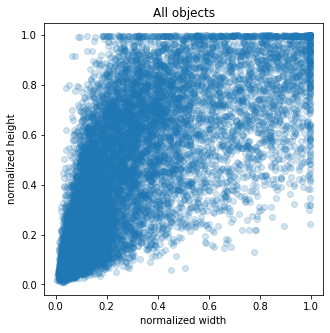

In [ ]:
'''Store the array results'''
objects_width_height = get_objects_width_height(train_images)
print(f'Number of objects = {objects_width_height.shape[0]}')
print(f'A sample object with normalized [width, height] = {objects_width_height[0]}')

plt.figure(figsize=(5, 5))
plt.scatter(objects_width_height[:, 0], objects_width_height[:, 1], alpha=0.2)
plt.title("All objects")
plt.xlabel("normalized width")
plt.ylabel("normalized height")
plt.show()

In [ ]:
class AnchorBoxFinder:
  def __init__(self, objects_width_height, total_clusters):
    self._objects_width_height = objects_width_height
    self._total_clusters = total_clusters
    self._calculate_kmeans()
  
  '''Finding intersection over union'''
  def _calculate_iou(self, centroid):
    centroid_area = centroid[0] * centroid[1]
    objects_area = self._objects_width_height[:, 0] * self._objects_width_height[:, 1]

    min_width = np.minimum(self._objects_width_height[:, 0], centroid[0]) 
    min_height = np.minimum(self._objects_width_height[:, 1], centroid[1])

    intersection_area = min_width * min_height
    union_area = (centroid_area + objects_area) - intersection_area

    return intersection_area / union_area
  
  def _calculate_kmeans(self):
    total_objects = self._objects_width_height.shape[0]
    distances = np.empty((total_objects, self._total_clusters))
    last_centroids_index = np.zeros((total_objects,))

    np.random.seed(42)
    centroids = self._objects_width_height[np.random.choice(total_objects, size=self._total_clusters, replace=False)]

    while True:
      for cluster_index in range(self._total_clusters):
        distances[:, cluster_index] = 1 - self._calculate_iou(centroids[cluster_index])
      
      nearest_centroids = np.argmin(distances, axis=1)
      if (last_centroids_index == nearest_centroids).all(): break

      for cluster in range(self._total_clusters):
        centroids[cluster] = np.mean(self._objects_width_height[nearest_centroids == cluster], axis=0)
      
      last_centroids_index = nearest_centroids
    
    iou_mean = 1 - np.mean(distances[np.arange(len(nearest_centroids)), nearest_centroids])

    self._centroids = centroids
    self._nearest_centroids = nearest_centroids
    self._iou_mean = iou_mean
  
  def get_centroids(self):
    return self._centroids
  
  def get_nearest_centroids(self):
    return self._nearest_centroids
  
  def get_iou_mean(self):
    return self._iou_mean
  
  def display_cluster(self):
    np.random.seed(42)
    color = [list(np.random.choice(range(255), size=3) / 255.) for _ in range(self._total_clusters)]

    for cluster_index in range(self._total_clusters):
      x = self._objects_width_height[self._nearest_centroids == cluster_index, 0]
      y = self._objects_width_height[self._nearest_centroids == cluster_index, 1]
      plt.plot(x, y, 'o', color=color[cluster_index], alpha=0.2)

    plt.plot(self._centroids[:, 0], self._centroids[:, 1], 'o', color='black', alpha=1)
    plt.xlabel('objects_width')
    plt.ylabel('objects_height')
    plt.title(f'{self._total_clusters} clusters')
    plt.show()

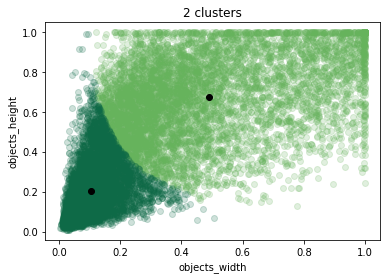

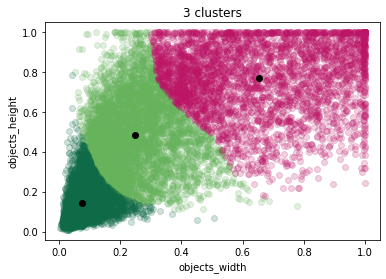

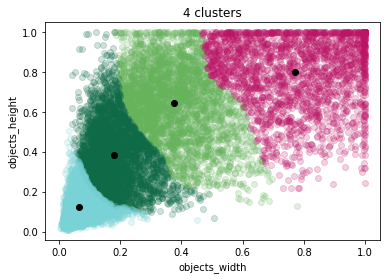

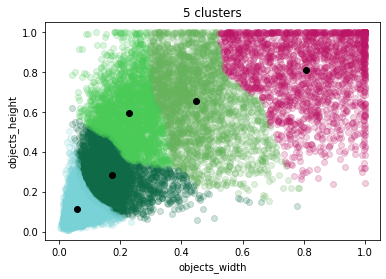

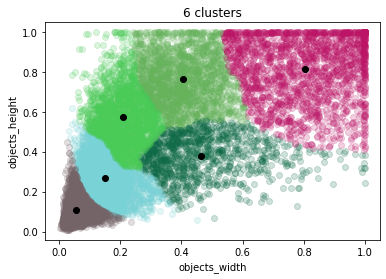

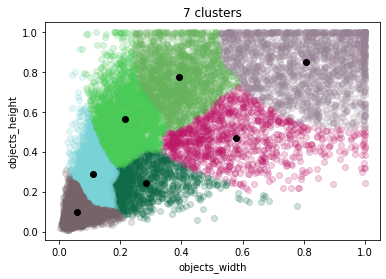

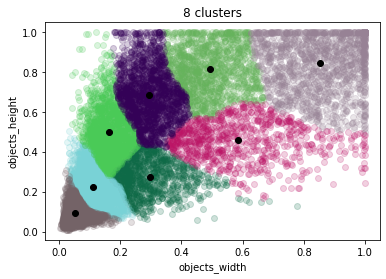

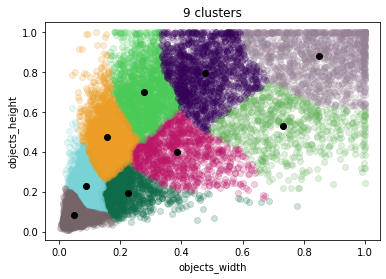

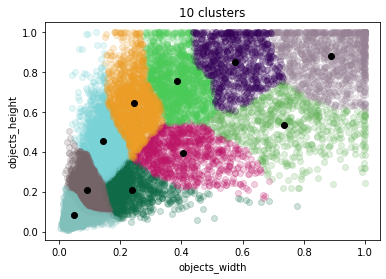

In [ ]:
total_clusters = 10
results = {}
for cluster_index in range(2, total_clusters + 1):
  anchor_box_finder = AnchorBoxFinder(objects_width_height, cluster_index)
  results[cluster_index] = {'centroids': anchor_box_finder.get_centroids(),
                            'nearest_centroids': anchor_box_finder.get_nearest_centroids(),
                            'iou_mean': anchor_box_finder.get_iou_mean()}
  anchor_box_finder.display_cluster()

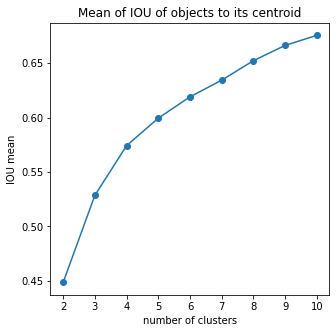

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(start=2, stop=total_clusters + 1, step=1),
         [results[cluster]['iou_mean'] for cluster in range(2, total_clusters + 1)], 'o-')
plt.title('Mean of IOU of objects to its centroid')
plt.ylabel('IOU mean')
plt.xlabel('number of clusters')
plt.show()

In [ ]:
results[4]['centroids']

array([[0.37578196, 0.64331881],
       [0.18122142, 0.38260921],
       [0.77190043, 0.79726407],
       [0.06688127, 0.12116184]])